# Probabilistic Scenario Analysis
Geltner & de Neufville (2018) continue in Chapter 5 to outline how scenario outcomes are based on the probability of certain situations or circumstances occuring. In Chapter 7, the qualities of real estate market dynamics are described, which are implemented in the Rangekeeper 'Dyanamics' module:

## Real Estate Pricing Factor Dynamics

Geltner & de Neufville (2018) document the following characteristics of real estate markets:
1. Non-substitutability and non-fungibility of real estate assets.
2. Inefficiency of information processing in real estate markets.
3. Autoregression in real estate pricing
4. Cyclicality in real estate pricing
5. Mean reversion in real estate pricing

Because of these, the real estate pricing dynamics that are input into simulations should include autoregression, cyclicality, and mean‐reversion, in addition to random-walk process.

The methodology to produce a simulation of a real estate market is by using 'pricing factors'; a ratio that multiplies the original, single‐stream pro forma cash flow expectation to arrive at a future cash flow outcome for a given scenario. The use of pricing factors as a way to develop representative
scenarios based on available data on the historical variations in market prices for real estate. In this methodology, the pricing factors substantially enhance the traditional random walk process, by recognizing the special features of the dynamics of real estate markets. The resulting output simulation distributions offer a much richer and fuller picture of the future than the traditional, single‐stream DCF.

```{figure} resources/FaREVuU-figure7.2.png
---
width: 100%
name: FaREVuU-figure7.2
---
Figure 7.2 From Geltner & De Neufville, 2018
```

The following demonstrates Rangekeeper's implementation of the 'MktDynamicsInputs' tab(s) used in the accompanying Excel spreadsheets to Geltner & de Neufville (2018).

In [1]:
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import rangekeeper as rk

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:

period_type = rk.periodicity.Type.YEAR
span = rk.span.Span.from_num_periods(
    name="Span",
    date=pd.Timestamp(2001, 1, 1),
    period_type=period_type,
    num_periods=25)
span

Span: Span
Start Date: 2001-01-01
End Date: 2025-12-31

### Overall Trend

First, we set up the general (rental) market trend (excluding volatility), which requires the following parameters:

```{margin}
```{dropdown} Initial Price Factor
This governs the base rental (net income) value as a fraction of asset value. To normalize the values by giving them a "base" value of 1.00, we have set this equal to the cap rate (net income yield). This will make the resulting rental market price factor 1.00 in Year 0, such that subsequent price factors will be ratios of the pro-forma cash flow expectations.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

```{margin}
```{dropdown} Cap Rate
This is the long-run mean cap rate around which the capital market cycle varies, that is, this is the cap rate toward which the market reverts over the cycle. This relates to the reversion (going-out) cap rate that will be applied upon resale.

You can set this so that the inflexible (10yr) reversion will exactly match a pro-forma reversion amount in the Base Case. Just set this as the ratio of the pro-forma Yr11 NOI divided by the pro-forma reversion (gross of selling expenses).

Note that if this long-run cap rate is set to a value much above (below) the going-in cap rate implied by the initial price, then the result will be to tend to favor flexible resale timing later (earlier), so as to mitigate (maximize) the unfavorable (favorable) effect of the yield change between the buy and the sell.

A plausible value for this input would equal the discount rate minus the pro-forma growth rate, plus 100 to 200 basis-points for capital improvements expenditures.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

```{margin}
```{dropdown} Rent Residual
The residual is used to model the uncertainty in the initial rent estimated in the pro-forma. In {cite}`farevuu2018`, this is the half-range of a triangular distribution as a proportion of Initial Rent Price Factor (entered above). Using Rangekeeper, additional distribution forms are also available, if wanted. Typically you wouldn't enter more than 0.05 or 0.1 here, at most. Initial rents should be able to be estimated pretty accurately in the realistic pro-forma, especially for existing buildings.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

```{margin}
```{dropdown} Long-run Trend Mean
This will govern the central tendency of the long-run growth rate trend that will apply over the entire scenario. As Pricing Factors are only RELATIVE TO the traditional pro-forma which should contain any realistic expected growth, the default value input here should normally be zero in principle. However, in the Base Case we make this incremental trend slightly negative to counteract the effect of some minor inconsistencies. (The pro forma does not recognize any Black Swan probability, and has zero selling expenses. The cap rate cycle is symmetric in the cap rate, but that gives resulting capital value levels an upward bias. These factors may interact with other elements of the price dynamics.) Ideally for a more representative sample and better "apples-to-apples" comparisons, you want to set this input so that the t-statistic of the InflxPV-ProFormaPV (cell K13) is generally near zero (and almost always < 1.96 in absolute value). You may need to change the LR Trend Mean input as you change other price dynamics input parameter assumptions away from the Base Case assumptions.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

```{margin}
```{dropdown} Long Run Trend Residual
This is to model uncertainty in the long-run trend growth rate (that applies throughout the entire scenario. In {cite}`farevuu2018`, this is modeled as a triangular distribution (again Rangekeeper provides other distributions easily), and the half-range should typically be a small value, at most .01 or .02, unless there is great uncertainty in the long-run average growth rate in the economy (such as perhaps in some emerging market countries), or if one is modeling nominal values and there is great uncertainty about what the future rate of inflation will be (but in such cases it is better to model real values, net of inflation anyway).

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

In [3]:
trend_params = {
    'initial_price_factor': 1.,
    'cap_rate': .05,
    'rent_residual': .005,
    'trend_mean': -0.0005,
    'trend_residual': .005,
    }
trend_params['rent_mean'] = trend_params['cap_rate'] * trend_params['initial_price_factor']

Rangekeeper can now produce the trend for the rental market:

Trend Specification:
Initial Rent: 0.0488
Growth Rate: -0.0005


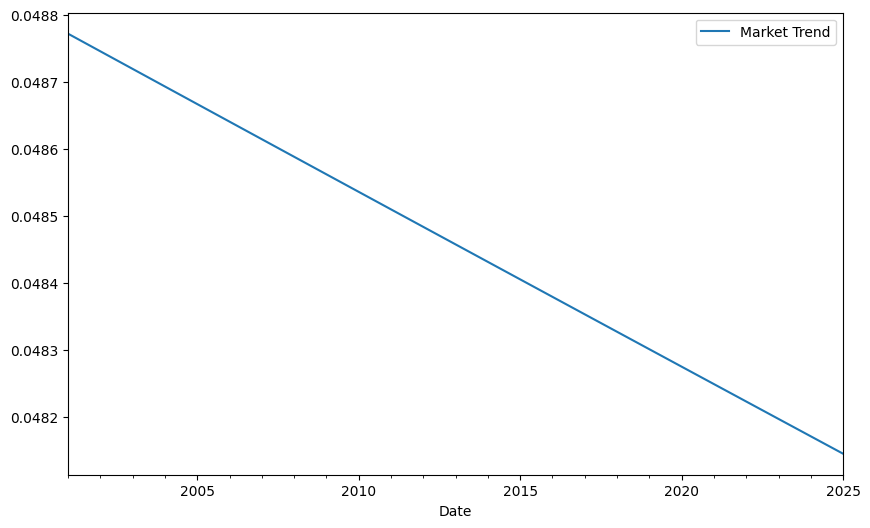

In [4]:
market_trend = rk.dynamics.trend.Trend(
    span=span,
    period_type=period_type,
    params=trend_params)
print('Trend Specification:\nInitial Rent: {0}\nGrowth Rate: {1}'.format(round(market_trend.initial_rent, 4), round(market_trend.trend_rate, 4)))
market_trend.trend.plot()

To introduce volatility, we require the following parameters:

```{margin}
```{dropdown} Volatility:
"Volatility" refers to the standard deviation across time (longitudinal dispersion), in the changes or returns (differences from one period to the next). Volatility "accumulates" in the sense that the realization of the change in one period becomes embedded in the level (of rents) going forward into the next period, whose change is then added on top of the previous level (of rents). The volatility realizations tracked in this column apply only to the "innovations" in the rent level. If there is autoregression (next columns) then that will also affect the annual volatility in the rent changes.

Evidence indicates that in mature markets such as the U.S., real estate market volatility (not including individual building idiosyncratic risk) is on the order of 10%. However, this includes the effect of long-term cycles as well as annual accumulating volatility. If you are modeling an individual stabilized building, then you should probably set this in the range of 10% to 15% (which would reflect some idiosyncratic risk as well as market risk).

This is a normal (Gaussian) distribution. Note that volatility is realized (new random increment is generated) in EACH period, so that this "risk" outcome accumulates in the history of rent levels. But this is just the volatility in the innovations. If there is autoregression then that will also affect the annual volatility. Cycles well also affect the average volatility observed  empirically across the scenario.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

```{margin}
```{dropdown} Autoregression:
This reflects the inertia in the price movements.

Unless overriden by input on the Dashboard, enter here a value which for the relevant market indicates the degree of inertia. This is the autoregression parameter, which indicates what proportion of the previous period's return (price change) will automatically become a component of the current period's return (price change). In most real estate markets this would typically be a positive fraction, perhaps in the range +0.1 to +0.5. In more liquid and informationally efficient asset markets such as stock markets you might leave this at zero (no inertia). A "noisy" market would have a negative autoregression parameter, however, we deal with noise separately in a column farther to the right.

This is the proportion of the current period's return that will be "baked in" reflecting the previous period's return. The greater this parameter (which must be >0 & < 1), the more inertia or momentum the real estate prices will have. Empirical evidence indicates that this should probably be a small positive fraction, perhaps in the neighborhood of 0.2.
```

```{margin}
```{dropdown} Mean Reversion:
This is the mean reversion parameter. It determines the strength (or speed) of the mean reversion tendency in the price levels. It is the proportion of the previous period's difference of the price level from the long-term trend price level that will be eliminated in the current price level. This parameter should be between zero and 1, probably not very close to 1. For example, if the previous price level were 1.0, and the long-term trend price level for that period were 1.2, and if the mean reversion parameter were 0.5, then 0.5*(1.2-1.0) = 0.10 will be added to this period's price level.  Input here may be overriden by input on the Dashboard sheet.

This parameter will also impart inertia or momentum into the real estate prices, but in a special way, pulling the prices back towards the long-run trend level (not including any cycle that is in the price dynamics). This parameter is the proportion of the deviation between the current price level and the long-run trend level that will be reduced in each year. Evidence suggests that a mean reversion rate on the order of 0.1 to 0.4 is probably appropriate, especially for individual properties (as distinct from total market aggregates).
```

In [5]:
volatility_params = {
    'volatility_per_period': .1,
    'autoregression_param': .2,
    'mean_reversion_param': .3,
    }

In [6]:
market_volatility = rk.dynamics.volatility.Volatility(
    trend=market_trend,
    params=volatility_params)

We can now see the volatility with respect to the trend:

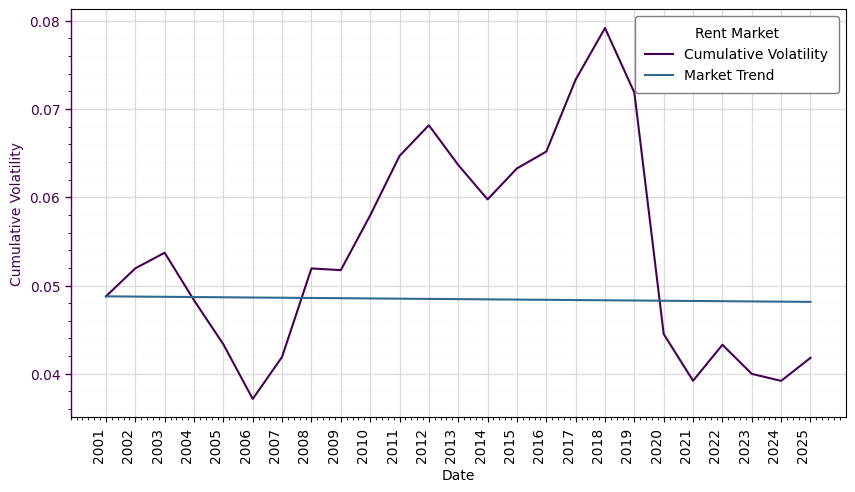

In [7]:
rent_market = rk.flux.Stream(
    name='Rent Market',
    flows=[market_volatility.cumulative_volatility, market_trend.trend],
    period_type=period_type)
rent_market.plot(normalize=True)

### Cyclicality

This models a (possibly somewhat) predictable long-term cycle in the pricing. In fact, there are two cycles, not necessarily in sync, one for the space market (rents) and another separate cycle for the asset market (capital flows), the latter reflected by the cap rate. We model each separately, the space market cycle in this column and the asset market cycle in a column to the right. Cycles are modeled by generalized sine functions governed by the given input period, amplitude, and phase.


```{margin}
```{dropdown} Space Cycle Period:
In the U.S. the real estate market cycle seems to be in the range of 10 to 20 years. This will randomly generate the cycle period governing each future history to be between 10 and 20 years.
```


```{margin}
```{dropdown} Space Cycle Span:
If you make this equal to a uniform random variable times the rent cycle period then the span will range from starting anywhere from peak to trough with equal likelihood.
E.g.:
'rent_cycle_span_mean' = distribution.Uniform().sample() * rent_cycle_period_avg,

If you think you know where you are in the cycle, then use this relationship of Span to Cycle Period:
Span:         Cycle:
(1/4)Period = Bottom of cycle, headed up.
(1/2)Period = Mid-cycle, headed down.
(3/4)Period = Top of cycle, headed down.
(1/1)Period = Mid-cycle, headed up.

Example, if you enter 20 in cycle period, and you enter 5 in cycle span, then the cycle will be starting out in the first year at the bottom of the cycle, heading up from there.

Please note that with the compound-sine asymetric cycle formula, the peak parameter is slightly off from the above; 0.65*Period seems to start the cycle closer to the peak.
For example, if you want the span to vary randomly and uniformly over the 1/8 of the cycle that is the top of the upswing (late boom just before downturn), you would enter:
.175 * distribution.Uniform().sample() +.65 * rent_cycle_period_avg
```

```{margin}
```{dropdown} Space Cycle Amplitude:
This is the peak-to-trough full cycle amplitude as a fraction of the mid-cycle level. Historically in the U.S. such cycles in investment property have been as much as 50% or more in some markets in the rental market (including both rent prices & occupancy effect and considering the leverage that fixed operating expenses have on the bottom-line net cash flow). The Pricing Factors in this model apply to net cash flows, not just top-line potential gross rental revenue.
```

```{margin}
```{dropdown} Asset Cycle Span:
This cap rate cycle input is the negative of the actual cap rate cycle, you can think of the span in the same way as the space market span. These two cycles are not generally exactly in sync, but the usually are not too far off. Hence, probably makes sense to set this asset market span equal to the space market span +/- some random difference that is a pretty small fraction of the cycle period.

Remember that peak-to-trough is half period, LR mean to either peak or trough is quarter period.
E.g.: rent_cycle_span + (distribution.Uniform().sample() * cap_rate_cycle_period/5) - cap_rate_cycle_period/10
Above would let asset span differ from space span by +/- a bit less than a quarter-period (here, a fifth of the asset cycle period).
```

```{margin}
```{dropdown} Asset Cycle Amplitude:
This is in cap rate units, so keep in mind the magnitude of the initial cap rate entered previously. For example, if the initial (base) cap rate entered there is 5.00%, and you enter 2.00% here, then this will mean a cap rate cycle swinging between 4.00% & 6.00%, which corresponds roughly to a property value swing of +/-20% (other things equal).

Note also that because this cycle is symmetric but operates in the denominator of the pricing factors governing the simulated future cash flows,
this cycle imparts a positive bias into the project ex post cash flows relative to the proforma expected cash flows.
```

In [8]:
cyclicality_params = {
        'space_cycle_period_mean': 15.,
        'space_cycle_period_residual': 5.,
        'space_cycle_period_dist': rk.distribution.Type.uniform,

        'space_cycle_span_offset': .175,
        'space_cycle_span_residual': .05,
        'space_cycle_span_dist': rk.distribution.Type.PERT,

        'space_cycle_amplitude_mean': .15,
        'space_cycle_amplitude_residual': .025,
        'space_cycle_amplitude_dist': rk.distribution.Type.uniform,

        'asset_cycle_period_offset': 0.,
        'asset_cycle_period_residual': 1.,
        'asset_cycle_period_dist': rk.distribution.Type.uniform,

        'asset_cycle_span_offset': 0.,
        'asset_cycle_span_residual': .2,
        'asset_cycle_span_dist': rk.distribution.Type.uniform,

        'asset_cycle_amplitude_mean': .01,
        'asset_cycle_amplitude_residual': .0015,
        'asset_cycle_amplitude_dist': rk.distribution.Type.PERT,

        'space_cycle_asymmetric_parameter': .5,
        'asset_cycle_asymmetric_parameter': .5
        }

In [9]:
market_cyclicality = rk.dynamics.cyclicality.Cyclicality(
    params=cyclicality_params,
    index=market_trend.trend.movements.index)

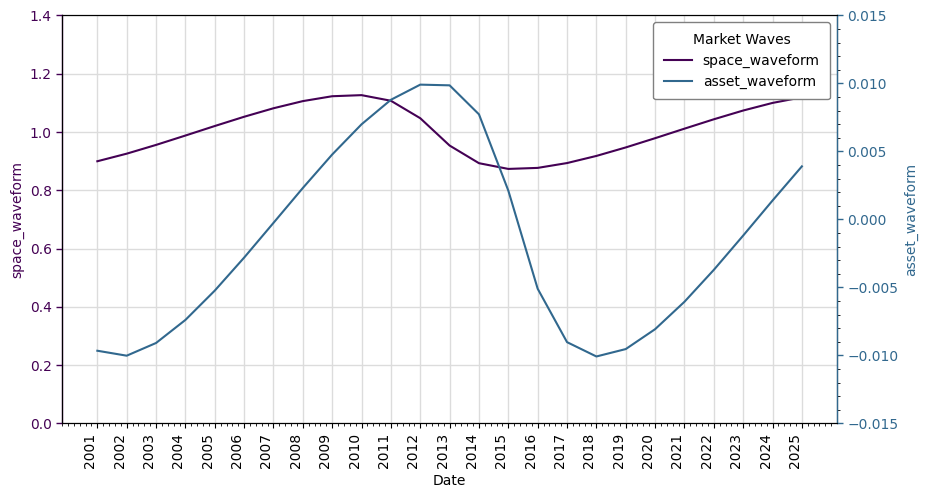

In [10]:
market_waves = rk.flux.Stream(
    name='Market Waves',
    flows=[market_cyclicality.space_waveform, market_cyclicality.asset_waveform],
    period_type=period_type)
market_waves.plot(
    flows={
        'space_waveform': (0, 1.4),
        'asset_waveform': (-0.015, 0.015)
        }
    )

In [11]:
market_params = {
    'noise_residual': .015,
    'cap_rate': trend_params['cap_rate'],
    'black_swan_likelihood': .05,
    'black_swan_dissipation_rate': volatility_params['mean_reversion_param'],
    'black_swan_impact': rk.distribution.PERT(
        peak=-.3,
        weighting=4.,
        minimum=-.4,
        maximum=-.2).sample(),
    'black_swan_prob_dist': rk.distribution.Uniform()
    }

In [12]:
market_dynamics = rk.dynamics.market.Market(
    params=market_params,
    trend=market_trend,
    volatility=market_volatility,
    cyclicality=market_cyclicality)

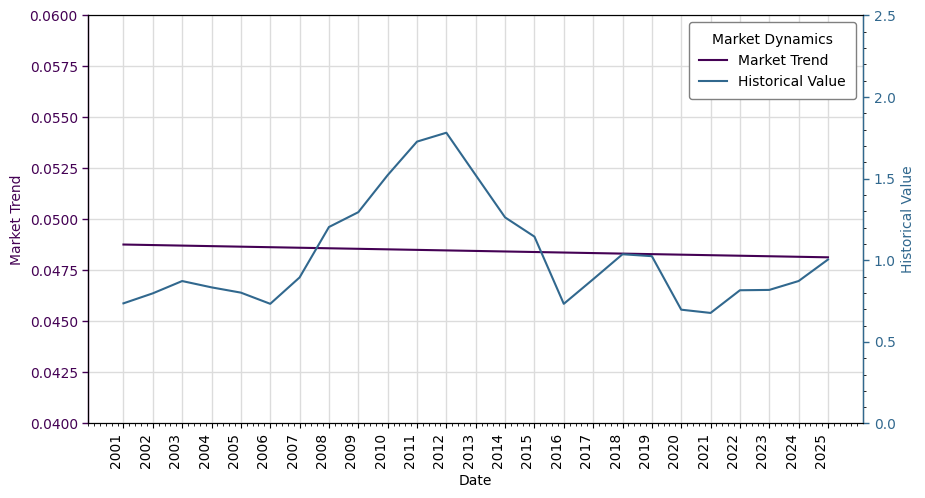

In [13]:
rk.flux.Stream(
    name='Market Dynamics',
    flows=[market_trend.trend, market_dynamics.historical_value],
    period_type=period_type).plot(
        flows={
            'Market Trend': (.04, .06),
            'Historical Value': (0, 2.5)
            }
        )

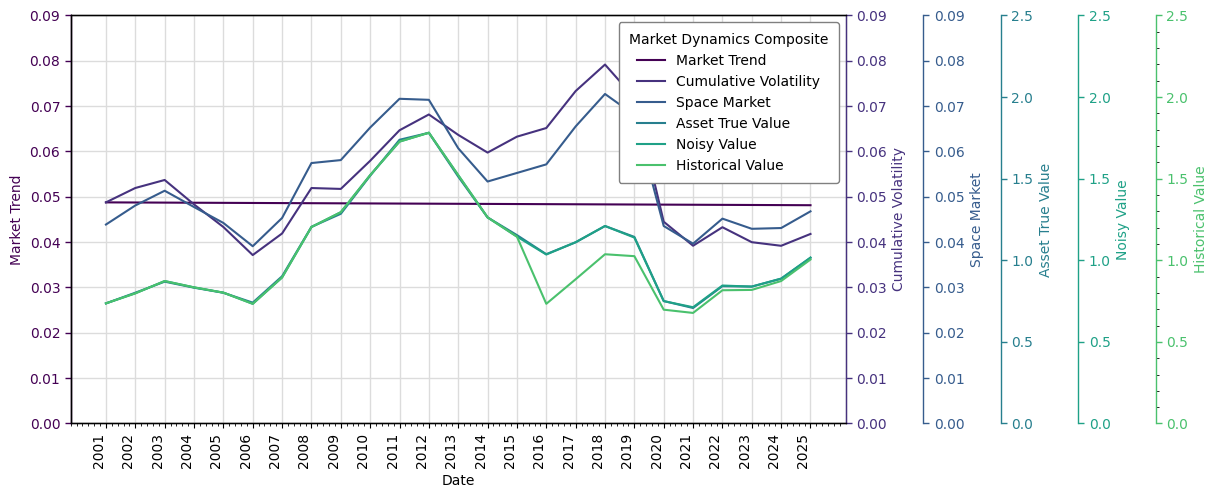

In [15]:
rk.flux.Stream(
    name='Market Dynamics Composite',
    flows=[
        market_trend.trend,
        market_volatility.cumulative_volatility,
        market_dynamics.space_market,
        market_dynamics.asset_true_value,
        market_dynamics.noisy_value,
        market_dynamics.historical_value
        ],
    period_type=period_type).plot(
        flows={
            'Market Trend': (0, .09),
            'Cumulative Volatility': (0, .09),
            'Space Market': (0, .09),
            'Asset True Value': (0, 2.5),
            'Noisy Value': (0, 2.5),
            'Historical Value': (0, 2.5)
            }
    )